# Projet Machine Learning : Detection of Attack on IoT Device

In [ ]:
from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


Importation du dataset

In [40]:
# fetch dataset
rt_iot2022 = fetch_ucirepo(id=942)

# data (as pandas dataframes)
X = rt_iot2022.data.features
y = rt_iot2022.data.targets

# metadata
print(rt_iot2022.metadata)

# variable information
print(rt_iot2022.variables)


{'uci_id': 942, 'name': 'RT-IoT2022 ', 'repository_url': 'https://archive.ics.uci.edu/dataset/942/rt-iot2022', 'data_url': 'https://archive.ics.uci.edu/static/public/942/data.csv', 'abstract': 'The RT-IoT2022, a proprietary dataset derived from a real-time IoT infrastructure, is introduced as a comprehensive resource integrating a diverse range of IoT devices and sophisticated network attack methodologies. This dataset encompasses both normal and adversarial network behaviours, providing a general representation of real-world scenarios.\nIncorporating data from IoT devices such as ThingSpeak-LED, Wipro-Bulb, and MQTT-Temp, as well as simulated attack scenarios involving Brute-Force SSH attacks, DDoS attacks using Hping and Slowloris, and Nmap patterns, RT-IoT2022 offers a detailed perspective on the complex nature of network traffic. The bidirectional attributes of network traffic are meticulously captured using the Zeek network monitoring tool and the Flowmeter plugin. Researchers can

## Analyse descriptive

In [41]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123117 entries, 0 to 123116
Data columns (total 83 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id.orig_p                 123117 non-null  int64  
 1   id.resp_p                 123117 non-null  int64  
 2   proto                     123117 non-null  object 
 3   service                   123117 non-null  object 
 4   flow_duration             123117 non-null  float64
 5   fwd_pkts_tot              123117 non-null  int64  
 6   bwd_pkts_tot              123117 non-null  int64  
 7   fwd_data_pkts_tot         123117 non-null  int64  
 8   bwd_data_pkts_tot         123117 non-null  int64  
 9   fwd_pkts_per_sec          123117 non-null  float64
 10  bwd_pkts_per_sec          123117 non-null  float64
 11  flow_pkts_per_sec         123117 non-null  float64
 12  down_up_ratio             123117 non-null  float64
 13  fwd_header_size_tot       123117 non-null  i

In [42]:
X.nunique()

id.orig_p               65478
id.resp_p                1809
proto                       3
service                    10
flow_duration           16381
                        ...  
idle.avg                 5670
idle.std                 1001
fwd_init_window_size       20
bwd_init_window_size       56
fwd_last_window_size      109
Length: 83, dtype: int64

In [43]:
X.describe(include = 'all')

,id.orig_p,id.resp_p,proto,service,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,...,flow_pkts_payload.std,fwd_iat.min,fwd_iat.max,fwd_iat.tot,fwd_iat.avg,fwd_iat.std,bwd_iat.min,bwd_iat.max,bwd_iat.tot,bwd_iat.avg,bwd_iat.std,flow_iat.min,flow_iat.max,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size
count,123117.000000,123117.000000,123117,123117,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,1.231170e+05,1.231170e+05,1.231170e+05,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,123117.0,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,123117.000000,1.231170e+05,123117.000000,123117.000000,123117.000000,...,123117.000000,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,123117.000000,123117.000000,123117.000000,1.231170e+05,123117.000000,1.231170e+05,123117.000000,123117.000000,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,1.231170e+05,123117.000000,123117.000000,123117.000000
unique,NaN,NaN,3,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,tcp,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,110427,102861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,34639.258738,1014.305092,NaN,NaN,3.809566,2.268826,1.909509,1.471218,0.820260,3.518063e+05,3.517620e+05,7.035683e+05,0.854571,53.892379,19.779397,20.646637,46.626900,17.695915,18.432678,0.115605,0.950868,0.796454,0.351332,0.393634,2.677737,0.016293,0.0,0.001007,0.000699,96.256073,120.749133,221.519108,100.523827,8.107768,3.817523,52.405005,5.129981e+02,18.786782,20.553025,13.554440,...,76.041654,8.843266e+03,1.721566e+06,3.780208e+06,2.373575e+05,5.775574e+05,3.764849e+03,4.077267e+05,1.779893e+06,8.765213e+04,1.474803e+05,4.283079e+03,1.725999e+06,3.810575e+06,1.396545e+05,4.501362e+05,4.105345e+07,1.551715,1.337718,136.479504,2.17517

In [44]:
X.isnull().sum()

id.orig_p               0
id.resp_p               0
proto                   0
service                 0
flow_duration           0
                       ..
idle.avg                0
idle.std                0
fwd_init_window_size    0
bwd_init_window_size    0
fwd_last_window_size    0
Length: 83, dtype: int64

C:\Users\gaell\AppData\Local\Temp\ipykernel_23624\2940668927.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "Attack_type", data = y, palette="hls")


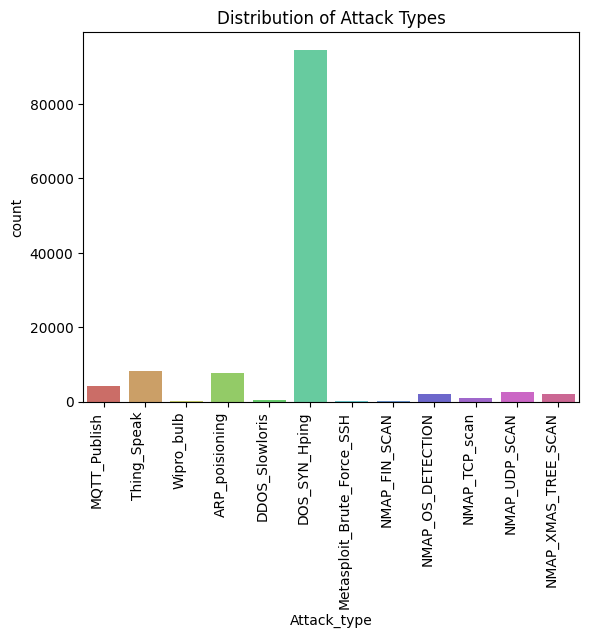

In [45]:
sns.countplot(x = "Attack_type", data = y, palette="hls")
plt.title("Distribution of Attack Types")
plt.xticks(rotation = 90, ha='right')
plt.show()

## Preprocessing

2 features are categorical. In order to use them in our model we need to encode. We use the OneHot Encoder.

In [46]:
categorical_feature = ['proto', 'service']
X[categorical_feature].describe()

,proto,service
count,123117,123117
unique,3,10
top,tcp,-
freq,110427,102861


In [47]:
onehot = OneHotEncoder(sparse_output = False)
encoded_categorical = onehot.fit_transform(X[categorical_feature])

encoded_df = pd.DataFrame(encoded_categorical, columns = onehot.get_feature_names_out(categorical_feature))
encoded_df.head()

,proto_icmp,proto_tcp,proto_udp,service_-,service_dhcp,service_dns,service_http,service_irc,service_mqtt,service_ntp,service_radius,service_ssh,service_ssl
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [48]:
X = X.drop(categorical_feature, axis = 1)
X = pd.concat([X, encoded_df], axis = 1)
X.head()

,id.orig_p,id.resp_p,flow_duration,fwd_pkts_tot,bwd_pkts_tot,fwd_data_pkts_tot,bwd_data_pkts_tot,fwd_pkts_per_sec,bwd_pkts_per_sec,flow_pkts_per_sec,down_up_ratio,fwd_header_size_tot,fwd_header_size_min,fwd_header_size_max,bwd_header_size_tot,bwd_header_size_min,bwd_header_size_max,flow_FIN_flag_count,flow_SYN_flag_count,flow_RST_flag_count,fwd_PSH_flag_count,bwd_PSH_flag_count,flow_ACK_flag_count,fwd_URG_flag_count,bwd_URG_flag_count,flow_CWR_flag_count,flow_ECE_flag_count,fwd_pkts_payload.min,fwd_pkts_payload.max,fwd_pkts_payload.tot,fwd_pkts_payload.avg,fwd_pkts_payload.std,bwd_pkts_payload.min,bwd_pkts_payload.max,bwd_pkts_payload.tot,bwd_pkts_payload.avg,bwd_pkts_payload.std,flow_pkts_payload.min,flow_pkts_payload.max,flow_pkts_payload.tot,...,flow_iat.tot,flow_iat.avg,flow_iat.std,payload_bytes_per_second,fwd_subflow_pkts,bwd_subflow_pkts,fwd_subflow_bytes,bwd_subflow_bytes,fwd_bulk_bytes,bwd_bulk_bytes,fwd_bulk_packets,bwd_bulk_packets,fwd_bulk_rate,bwd_bulk_rate,active.min,active.max,active.tot,active.avg,active.std,idle.min,idle.max,idle.tot,idle.avg,idle.std,fwd_init_window_size,bwd_init_window_size,fwd_last_window_size,proto_icmp,proto_tcp,proto_udp,service_-,service_dhcp,service_dns,service_http,service_irc,service_mqtt,service_ntp,service_radius,service_ssh,service_ssl
0,38667,1883,32.011598,9,5,3,3,0.281148,0.156193,0.437341,0.555556,296,32,40,168,32,40,0,2,1,3,3,13,0,0,0,0,0,33,76,8.444444,13.115936,0,23,32,6.4,9.555103,0,33,108,...,32011597.87,2.462431e+06,8.199747e+06,3.373777,3.0,1.666667,25.333333,10.666667,0.0,0.0,0.0,0.0,0.0,0.0,2282414.913,2282414.913,2282414.913,2282414.913,0.0,29729182.96,29729182.96,29729182.96,29729182.96,0.0,64240,26847,502,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,51143,1883,31.883584,9,5,3,3,0.282277,0.156821,0.439097,0.555556,296,32,40,168,32,40,0,2,1,3,3,13,0,0,0,0,0,33,76,8.444444,13.115936,0,23,32,6.4,9.555103,0,33,108,...,31883584.02,2.452583e+06,8.242459e+06,3.387323,3.0,1.666667,25.333333,10.666667,0.0,0.0,0.0,0.0,0.0,0.0,2028306.961,2028306.961,2028306.961,2028306.961,0.0,29855277.06,29855277.06,29855277.06,29855277.06,0.0,64240,26847,502,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,44761,1883,32.124053,9,5,3,3,0.280164,0.155647,0.435811,0.555556,296,32,40,168,32,40,0,2,1,3,3,13,0,0,0,0,0,33,74,8.222222,12.852799,0,21,30,6.0,8.689074,0,33,104,...,32124053.00,2.471081e+06,8.230593e+06,3.237450,3.0,1.666667,24.666667,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,2281903.982,2281903.982,2281903.982,2281903.982,0.0,29842149.02,29842149.02,29842149.02,29842149.02,0.0,64240,26847,502,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,60893,1883,31.961063,9,5,3,3,0.281593,0.156440,0.438033,0.555556,296,32,40,168,32,40,0,2,1,3,3,13,0,0,0,0,0,33,74,8.222222,12.852799,0,21,30,6.0,8.689074,0,33,104,...,31961063.15,2.458543e+06,8.257786e+06,3.253959,3.0,1.666667,24.666667,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,2047288.179,2047288.179,2047288.179,2047288.179,0.0,29913774.97,29913774.97,29913774.97,29913774.97,0.0,64240,26847,502,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,51087,1883,31.902362,9,5,3,3,0.282111,0.156728,0.438839,0.555556,296,32,40,168,32,40,0,2,1,3,3,13,0,0,0,0,0,33,76,8.444444,13.115936,0,23,32,6.4,9.555103,0,33,108,...,31902361.87,2.454028e+06,8.230584e+06,3.385329,3.0,1.666667,25.333333,10.666667,0.0,0.0,0.0,0.0,0.0,0.0,2087656.975,2087656.975,2087656.975,2087656.975,0.0,29814704.90,29814704.90,29814704.90,29814704.90,0.0,64240,26847,502,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Training model

Our dataset has 94 features after encoing categorical features. We are going to use a PCA to reduce the number of features and try to optimize it with a Linear Regression model.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

Scaling of the dataset

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Applying PCA and training of model

In [ ]:
model = LogisticRegression()
pca = PCA(n_components = 10)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

model.fit(X_train_pca, y_train)
y_pred = model.predict(X_test_pca)


c:\Users\gaell\Documents\ml_courses\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\gaell\Documents\ml_courses\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Evaluation of the model

In [52]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

c:\Users\gaell\Documents\ml_courses\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Accuracy: 0.976, Precision: 0.976, Recall: 0.976, F1: 0.975


In [ ]:
print(classification_report(y_test, y_pred))

c:\Users\gaell\Documents\ml_courses\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\gaell\Documents\ml_courses\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


                            precision    recall  f1-score   support

            ARP_poisioning       0.91      0.78      0.84      2306
            DDOS_Slowloris       0.65      0.38      0.48       154
             DOS_SYN_Hping       1.00      1.00      1.00     28409
              MQTT_Publish       0.99      1.00      0.99      1273
Metasploit_Brute_Force_SSH       0.00      0.00      0.00        11
             NMAP_FIN_SCAN       0.00      0.00      0.00         7
         NMAP_OS_DETECTION       0.99      1.00      0.99       622
             NMAP_TCP_scan       0.98      0.99      0.99       319
             NMAP_UDP_SCAN       0.87      0.97      0.92       750
       NMAP_XMAS_TREE_SCAN       1.00      0.98      0.99       582
               Thing_Speak       0.81      0.94      0.87      2424
                Wipro_bulb       0.93      0.16      0.28        79

                  accuracy                           0.98     36936
                 macro avg       0.76      0.6

c:\Users\gaell\Documents\ml_courses\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


# GridSearch or Hyperparameter optimization

# WDRO ?  
[link](https://skwdro.readthedocs.io/stable/examples/Builtin/logistic_regression.html)

# Cross Validation  
[link](https://www.statology.org/evaluating-and-improving-model-robustness-using-scikit-learn/)